# NYC Apartment Search

_[Project prompt](https://docs.google.com/document/d/1BYVyFBDcTywdUlanH0ysfOrNWPgl7UkqXA7NeewTzxA/edit#heading=h.bpxu7uvknnbk)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add code as you wish._

_**All code below should be consider "pseudo-code" - not functional by itself, and only an idea of a possible approach.**_

## Setup

In [ ]:
# All import statements needed for the project, for example:

import json
import pathlib
import urllib.parse

import geoalchemy2 as gdb
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import shapely
import sqlalchemy as db

from sqlalchemy.orm import declarative_base

: 

In [83]:
# Any constants you might need; some have been added for you

# Where data files will be read from/written to - this should already exist
DATA_DIR = pathlib.Path("data")
ZIPCODE_DATA_FILE = DATA_DIR / "zipcodes" / "nyc_zipcodes.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

NYC_DATA_APP_TOKEN = "FILL_ME_IN"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

# directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("queries")

In [84]:
# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()

## Part 1: Data Preprocessing

In [246]:
def load_and_clean_zipcodes(zipcode_datafile):
    # load data
    df = gpd.read_file(zipcode_datafile)
     
    # Set up the headers to pass the application token
    clean_columns = ['ZIPCODE','geometry']
    df = df[clean_columns]
    
    # Remove invalid data points by rows
    df = df.dropna()
    
    # Normalize column names to lowercase
    df.columns = df.columns.str.lower()
    df.rename(columns={'zipcode': 'zip_code'}, inplace=True)
    
    # remove duplicate zip codes
    df.drop_duplicates(subset='zip_code', keep='first', inplace=True)
    
    # Normalize SRID
    df['geometry'] = df['geometry'].to_crs("epsg:4326")
    
    return df


In [248]:
test_zipcode=load_and_clean_zipcodes(ZIPCODE_DATA_FILE)

test_zipcode

,zip_code,geometry
0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."
...,...,...
257,11414,"POLYGON ((-73.85068 40.67165, -73.84995 40.671..."
258,10310,"POLYGON ((-74.12065 40.64104, -74.12057 40.641..."
260,11249,"POLYGON ((-73.95805 40.72442, -73.95772 40.724..."
261,10162,"POLYGON ((-73.95133 40.76931, -73.95165 40.769..."


In [18]:
from datetime import datetime

In [47]:
def download_and_clean_311_data():
    
    #### Download the data
    # Set up the url obtained the data from
    url = "https://data.cityofnewyork.us/resource/erm2-nwe9.geojson"
    
    # Set up the headers to pass the application token
    header = {"X-App-Token": "oOu0LSU0TAyxOY44hvVXEv2hT"}

    # Set up the parameter to limit the number of rows and date range
    start_date = datetime.strptime('10/01/2022', '%m/%d/%Y').strftime('%Y-%m-%dT%H:%M:%S')
    end_date = datetime.strptime('09/30/2023', '%m/%d/%Y').strftime('%Y-%m-%dT%H:%M:%S')
    
    param = {"$limit": 5000
            } # Need to adjust later

    # Make the API request and download the geojson file to local
    response = requests.get(url, headers=header, params=param)
    
    with open("data/nyc_311.geojson", "wb") as file:
        file.write(response.content)
    
    df = gpd.read_file("data/nyc_311.geojson")
                       
    
    #### Clean the data
    # Select necessary columns and Remove the others
    clean_columns = ['unique_key','created_date','complaint_type','incident_zip','geometry']
    df = df[clean_columns]
    
    # Remove invalid data by rows
    df.dropna(inplace=True)
    
    # Normalize column names and types if needed
    df.rename(columns={'incident_zip': 'zip_code'}, inplace=True)
    df['unique_key'] = df['unique_key'].astype('Int64')
    df['zip_code'] = df['zip_code'].astype("string")
                       
    return df


In [48]:
test_311 = download_and_clean_311_data()
test_311

,unique_key,created_date,complaint_type,zip_code,geometry
0,59682706,2023-12-09 12:00:00,Derelict Vehicles,11412,POINT (-73.75719 40.69898)
1,59683999,2023-12-09 12:00:00,Derelict Vehicles,11357,POINT (-73.82518 40.77956)
2,59681385,2023-12-09 12:00:00,Derelict Vehicles,11222,POINT (-73.94549 40.71914)
3,59681790,2023-12-09 02:41:46,Graffiti,10032,POINT (-73.94337 40.83670)
4,59684401,2023-12-09 02:06:35,Graffiti,11211,POINT (-73.95151 40.71341)
...,...,...,...,...,...
4995,59684672,2023-12-08 13:36:48,Noise - Street/Sidewalk,11374,POINT (-73.86006 40.73133)
4996,59680022,2023-12-08 13:36:47,Street Sign - Dangling,11693,POINT (-73.82164 40.61487)
4997,59683351,2023-12-08 13:36:42,Noise - Residential,10466,POINT (-73.84512 40.88620)
4998,59684241,2023-12-08 13:36:25,Traffic,10011,POINT (-74.00470 40.74471)


In [23]:
def download_and_clean_tree_data():
    
    url = "https://data.cityofnewyork.us/resource/5rq2-4hqu.geojson"

    # Set up the headers to pass the application token
    header = {"X-App-Token": "oOu0LSU0TAyxOY44hvVXEv2hT"}

    # Set up the parameter to limit the number of rows
    param = {"$limit": 5000} #confirmed limits around 683788~ 684000 to used

    # Make the API request and converting the JSON response to obtain a dataframe
    response = requests.get(url,headers=header, params=param)
    
    with open("data/tree.geojson", "wb") as file:
        file.write(response.content)
        
    df = gpd.read_file("data/tree.geojson")
    
    #### Clean the data
    # Select necessary columns and Remove the others
    clean_columns = ['tree_id','created_at','zipcode','spc_common','health','status','geometry']
    df = df[clean_columns]

    
    # Remove invalid data by rows
    df.dropna(inplace=True)
    
    # Normalize column names and types if needed
    df.rename(columns={'zipcode': 'zip_code'}, inplace=True)
    df.rename(columns={'spc_common': 'species'}, inplace=True)
    
    df['geometry'] = df['geometry'].to_crs("epsg:4326")
    
    
    return df

In [56]:
test_tree= download_and_clean_tree_data()
test_tree

,tree_id,created_at,zip_code,species,health,status,geometry
0,180683,08/27/2015,11375,red maple,Fair,Alive,POINT (-73.84422 40.72309)
1,200540,09/03/2015,11357,pin oak,Fair,Alive,POINT (-73.81868 40.79411)
2,204026,09/05/2015,11211,honeylocust,Good,Alive,POINT (-73.93661 40.71758)
3,204337,09/05/2015,11211,honeylocust,Good,Alive,POINT (-73.93446 40.71354)
4,189565,08/30/2015,11215,American linden,Good,Alive,POINT (-73.97598 40.66678)
...,...,...,...,...,...,...,...
4995,189566,08/30/2015,11215,London planetree,Poor,Alive,POINT (-73.97608 40.66683)
4996,196084,09/02/2015,11415,London planetree,Good,Alive,POINT (-73.82802 40.70452)
4997,176319,08/26/2015,11692,golden raintree,Good,Alive,POINT (-73.78844 40.59284)
4998,172943,08/25/2015,11219,Schumard's oak,Good,Alive,POINT (-73.99084 40.62945)


In [181]:
geodf_tree_data.tail()

,tree_id,created_at,zip_code,species,health,status,geometry
683783,155433,08/18/2015,11211,pin oak,Good,Alive,POINT (-73.95494 40.71321)
683784,183795,08/29/2015,11375,Kentucky yellowwood,Good,Alive,POINT (-73.85665 40.71519)
683785,166161,08/22/2015,10314,red maple,Good,Alive,POINT (-74.13652 40.62076)
683786,184028,08/29/2015,10457,red maple,Good,Alive,POINT (-73.90311 40.85083)
683787,200607,09/03/2015,11365,red maple,Fair,Alive,POINT (-73.78753 40.73217)


In [86]:
def load_and_clean_zillow_data():
    # load the csv file
    df = gpd.read_file(ZILLOW_DATA_FILE)
    
    #### Clean the data
    # Filter out non-NYC cities
    df = df[df['City']=='New York']

    # Select necessary columns and Remove the others
    clean_columns = ['RegionID','RegionName',r'2023/08/31',r'2023/01/31']
    df = df[clean_columns]
    
    # Normalize column names and types if needed
    df.columns = df.columns.str.lower()
    df.rename(columns={'regionid': 'region_id'}, inplace=True)
    df.rename(columns={'regionname': 'zip_code'}, inplace=True)
    # df.rename(columns={r'2023/08/31': 'august2023'}, inplace=True)
    # df.rename(columns={r'2023/01/31': 'january2023'}, inplace=True)
    
    # df['august2023'] = pd.to_numeric(df['august2023'])
    # df['january2023'] = pd.to_numeric(df['january2023'])
    
    # Remove invalid data by rows
    df.dropna(inplace=True)
    
    return df

In [80]:
test_zillow=load_and_clean_zillow_data()
test_zillow

KeyError: "['2023/08/31', '2023/01/31'] not in index"

In [ ]:
def load_all_data():
    geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
    geodf_311_data = download_and_clean_311_data()
    geodf_tree_data = download_and_clean_tree_data()
    df_zillow_data = load_and_clean_zillow_data()
    return (
        geodf_zipcode_data,
        geodf_311_data,
        geodf_tree_data,
        df_zillow_data
    )

In [44]:
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

In [15]:
# Show basic info about each dataframe
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zip_code  263 non-null    object  
 1   geometry  263 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 4.2+ KB


In [16]:
# Show first 5 entries about each dataframe
geodf_zipcode_data.geometry

0      POLYGON ((-73.80585 40.68291, -73.80569 40.682...
1      POLYGON ((-73.93740 40.67973, -73.93487 40.679...
2      POLYGON ((-73.90294 40.67084, -73.90223 40.668...
3      POLYGON ((-73.95797 40.67066, -73.95576 40.670...
4      POLYGON ((-73.97208 40.65060, -73.97192 40.650...
                             ...                        
258    POLYGON ((-74.12065 40.64104, -74.12057 40.641...
259    POLYGON ((-73.84076 40.62536, -73.84306 40.627...
260    POLYGON ((-73.95805 40.72442, -73.95772 40.724...
261    POLYGON ((-73.95133 40.76931, -73.95165 40.769...
262    POLYGON ((-73.99354 40.75145, -73.99320 40.751...
Name: geometry, Length: 263, dtype: geometry

In [17]:
geodf_311_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4937 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   unique_key    4937 non-null   Int64         
 1   created_date  4937 non-null   datetime64[ns]
 2   zip_code      4937 non-null   string        
 3   geometry      4937 non-null   geometry      
dtypes: Int64(1), datetime64[ns](1), geometry(1), string(1)
memory usage: 197.7 KB


In [18]:
geodf_311_data.head()

,unique_key,created_date,zip_code,geometry
0,59674686,2023-12-08 12:00:00,10033,POINT (-73.92843 40.85199)
1,59670275,2023-12-08 12:00:00,11369,POINT (-73.87725 40.75788)
2,59667305,2023-12-08 12:00:00,10033,POINT (-73.93274 40.84632)
4,59667303,2023-12-08 12:00:00,10019,POINT (-73.99209 40.76428)
5,59676143,2023-12-08 12:00:00,11231,POINT (-74.01050 40.67327)


In [19]:
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4810 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   tree_id     4810 non-null   object  
 1   created_at  4810 non-null   object  
 2   zip_code    4810 non-null   object  
 3   species     4810 non-null   object  
 4   health      4810 non-null   object  
 5   status      4810 non-null   object  
 6   geometry    4810 non-null   geometry
dtypes: geometry(1), object(6)
memory usage: 300.6+ KB


In [20]:
geodf_tree_data.head()

,tree_id,created_at,zip_code,species,health,status,geometry
0,180683,08/27/2015,11375,red maple,Fair,Alive,POINT (-73.84422 40.72309)
1,200540,09/03/2015,11357,pin oak,Fair,Alive,POINT (-73.81868 40.79411)
2,204026,09/05/2015,11211,honeylocust,Good,Alive,POINT (-73.93661 40.71758)
3,204337,09/05/2015,11211,honeylocust,Good,Alive,POINT (-73.93446 40.71354)
4,189565,08/30/2015,11215,American linden,Good,Alive,POINT (-73.97598 40.66678)


In [21]:
df_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121 entries, 4 to 6721
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   region_id    121 non-null    object 
 1   zip_code     121 non-null    object 
 2   august2023   121 non-null    float64
 3   january2023  121 non-null    float64
dtypes: float64(2), object(2)
memory usage: 4.7+ KB


In [22]:
df_zillow_data.head()

,region_id,zip_code,august2023,january2023
4,62093,11385,3064.476503,2895.699421
6,62019,11208,2737.547470,2588.030194
13,61807,10467,2353.686402,2155.617718
14,62085,11373,2302.557354,2255.604528
15,62037,11226,2785.320137,2680.683700


## Part 2: Storing Data

In [23]:
DB_NAME = "Final_Project"
DB_USER = "postgres"
DB_URL = f"postgresql+psycopg2://{DB_USER}@localhost/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"

### Creating Database

In [24]:
!createdb Final_Project


createdb: error: database creation failed: ERROR:  database "Final_Project" already exists


In [25]:
!psql --dbname Final_Project -c 'CREATE EXTENSION postgis;'

ERROR:  extension "postgis" already exists


In [26]:
#pip install psycopg2-binary

In [27]:
import psycopg2

In [28]:
def setup_new_postgis_database(username, db_name):
    conn = psycopg2.connect(dbname=db_name, user=username)
    return conn

In [29]:
setup_new_postgis_database(DB_USER, DB_NAME)

<connection object at 0x2812538b0; dsn: 'dbname=Final_Project user=postgres', closed: 0>

### Creating Tables


These are just a couple of options to creating your tables; you can use one or the other, a different method, or a combination.

In [30]:
engine = db.create_engine(DB_URL)

In [39]:
# if using SQL (as opposed to SQLAlchemy), define the SQL statements to create your 4 tables
ZIPCODE_SCHEMA = """
CREATE TABLE IF NOT EXISTS zipcodes
(
    id INTEGER PRIMARY KEY,
    zip_code CHAR(5),
    geometry GEOMETRY(Polygon,4326)
)
"""

NYC_311_SCHEMA = """
CREATE TABLE IF NOT EXISTS complaints
(
    id INTEGER PRIMARY KEY,
    complaint_id INTEGER,
    date Date,
    zip_code CHAR(5),
    geometry GEOMETRY(Point,4326)
)
"""
    
NYC_TREE_SCHEMA = """
CREATE TABLE IF NOT EXISTS trees
(
    id INTEGER PRIMARY KEY,
    tree_id INTEGER,
    date Date,
    zip_code CHAR(5),
    species TEXT,
    health TEXT,
    status TEXT,
    geometry GEOMETRY(Point,4326)
)
"""


ZILLOW_SCHEMA = """
CREATE TABLE IF NOT EXISTS rents
(
    id INTEGER PRIMARY KEY,
    region_id INTEGER,
    zip_code CHAR(5),
    August2023 FLOAT,
    January2023 FLOAT
)
"""

In [40]:
# create that required schema.sql file
with open(DB_SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA + ";\n")
    f.write(NYC_311_SCHEMA + ";\n")
    f.write(NYC_TREE_SCHEMA + ";\n")
    f.write(ZILLOW_SCHEMA + ";\n")

In [41]:
# If using SQL (as opposed to SQLAlchemy), execute the schema files to create tables
with engine.connect() as connection:
    connection.execute(open(DB_SCHEMA_FILE, "r").read())

### Add Data to Database

These are just a couple of options to write data to your tables; you can use one or the other, a different method, or a combination.

#### Option 1: SQL

In [131]:
def write_dataframes_to_table(tablename_to_dataframe):
    # tablename_to_dataframe is a dictionary having tablename as the key and the loaded dataframe as the value
    
    for table, df in tablename_to_dataframe.items():
        # Add data to table with geospatial data
        if isinstance(df, gpd.GeoDataFrame):
            df.to_postgis(table, con=engine, if_exists='replace', index=False)
        # Add data to table without geospatial data
        else:
            df.to_sql(table, con=engine, if_exists='replace', index=False)

In [132]:
tablename_to_dataframe = {
    "zipcodes": geodf_zipcode_data,
    "complaints": geodf_311_data,
    "trees": geodf_tree_data,
    "rents": df_zillow_data,
}

In [133]:
write_dataframes_to_table(tablename_to_dataframe)

In [134]:
# Check the table: (Delete later)
with engine.connect() as connection:
    df = pd.read_sql("SELECT * from zipcodes ", connection)
print(df)

    zip_code                                           geometry
0      11436  0103000020E6100000010000009F0000002BFF7C059373...
1      11213  0103000020E610000001000000A2000000FB8CA252FE7B...
2      11212  0103000020E6100000010000001A01000024C269CAC979...
3      11225  0103000020E610000001000000A0000000DAA0A86E4F7D...
4      11218  0103000020E610000001000000210100000FB6A093367E...
..       ...                                                ...
258    10310  0103000020E61000000100000045030000C5627BABB887...
259    11693  0103000020E6100000010000000F0000001CB328FDCE75...
260    11249  0103000020E610000001000000B9030000747D41B6507D...
261    10162  0103000020E6100000010000000C0000002E59248FE27C...
262    10119  0103000020E61000000100000008000000DD9DD03A967F...

[263 rows x 2 columns]


## Part 3: Understanding the Data

In [47]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as file:
        file.write(query)
    

### Query 1

In [48]:
QUERY_1_FILENAME = QUERY_DIR / "Area_By_Complaints"

QUERY_1 = """
SELECT
    zip_code,
    COUNT(*) AS num_complaints
FROM
    complaints
WHERE
    created_date BETWEEN '2022-10-01' AND '2023-09-30'
GROUP BY
    zip_code
ORDER BY
    num_complaints DESC
"""

In [49]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_1))
    for row in result:
        print(row)

In [50]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

In [51]:
# Able to delete later
with engine.connect() as connection:
    df = pd.read_sql_query(QUERY_1, connection)
print(df)

Empty DataFrame
Columns: [zip_code, num_complaints]
Index: []


### Query 2

In [71]:
QUERY_2_FILENAME = QUERY_DIR / "Top10_Greenery"

QUERY_2 = """
SELECT
    zip_code,
    COUNT(*) AS num_trees
FROM
    trees
GROUP BY
    zip_code
ORDER BY
    num_trees DESC
LIMIT 10
"""

In [72]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_2))
    for row in result:
        print(row)
    

('10306', 180)
('11105', 176)
('11375', 157)
('10457', 136)
('11215', 127)
('10024', 123)
('10458', 120)
('11230', 115)
('11205', 112)
('10312', 107)


In [73]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

In [74]:
# Able to delete later
with engine.connect() as connection:
    df = pd.read_sql_query(QUERY_2, connection)
print(df)

  zip_code  num_trees
0    10306        180
1    11105        176
2    11375        157
3    10457        136
4    11215        127
5    10024        123
6    10458        120
7    11230        115
8    11205        112
9    10312        107


### Query 3

In [75]:
QUERY_3_FILENAME = QUERY_DIR / "Top10_Greenery"
###### we only have 9 in the test
QUERY_3 = """
SELECT 
    top10trees.zip_code,
    ROUND(CAST(rents.august2023 AS numeric),2) AS average_rent

FROM (
    SELECT zip_code,COUNT(*) AS num_trees
    FROM trees
    GROUP BY zip_code
    ORDER BY num_trees DESC
    LIMIT 10
    )as top10trees
JOIN 
    rents ON top10trees.zip_code = rents.zip_code
ORDER BY 
    top10trees.num_trees DESC
"""

In [76]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_3))
    for row in result:
        print(row)

('10306', Decimal('2331.54'))
('11105', Decimal('2852.73'))
('11375', Decimal('2743.40'))
('10457', Decimal('2183.97'))
('11215', Decimal('3575.65'))
('10024', Decimal('3797.94'))
('10458', Decimal('1991.63'))
('11230', Decimal('2657.04'))
('11205', Decimal('3497.47'))


In [77]:
with engine.connect() as connection:
    df = pd.read_sql_query(QUERY_3, connection)
print(df)

  zip_code  average_rent
0    10306       2331.54
1    11105       2852.73
2    11375       2743.40
3    10457       2183.97
4    11215       3575.65
5    10024       3797.94
6    10458       1991.63
7    11230       2657.04
8    11205       3497.47


### Query 4

In [78]:
QUERY_4_FILENAME = QUERY_DIR / "Rent_Tree_Complaint"

QUERY_4 =  """
SELECT 
    rent_low.zip_code, 
    rent_low.average_rent, 
    COALESCE(tree_count.num_trees, 0) AS num_trees,
    COALESCE(complaint_count.num_complaints, 0) AS num_complaints
FROM(
    SELECT zip_code, ROUND(CAST(january2023 AS numeric),2) as average_rent
    FROM rents
    ORDER BY average_rent ASC
    LIMIT 5
    ) AS rent_low
LEFT JOIN (
    SELECT zip_code, COUNT(*) AS num_trees
    FROM trees
    GROUP BY zip_code
    ) AS tree_count ON rent_low.zip_code = tree_count.zip_code  
LEFT JOIN (
    SELECT zip_code, COUNT(*) AS num_complaints
    FROM complaints
    GROUP BY zip_code
    ) AS complaint_count ON rent_low.zip_code = complaint_count.zip_code

UNION ALL
    
SELECT 
    rent_low.zip_code, 
    rent_low.average_rent, 
    COALESCE(tree_count.num_trees, 0) AS num_trees,
    COALESCE(complaint_count.num_complaints, 0) AS num_complaints
FROM(
    SELECT zip_code, ROUND(CAST(january2023 AS numeric),2) as average_rent
    FROM rents
    ORDER BY average_rent DESC
    LIMIT 5
    ) AS rent_low
LEFT JOIN (
    SELECT zip_code, COUNT(*) AS num_trees
    FROM trees
    GROUP BY zip_code
    ) AS tree_count ON rent_low.zip_code = tree_count.zip_code  
LEFT JOIN (
    SELECT zip_code, COUNT(*) AS num_complaints
    FROM complaints
    GROUP BY zip_code
    ) AS complaint_count ON rent_low.zip_code = complaint_count.zip_code
    
ORDER BY average_rent
    
 """
    

In [79]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_4))
    for row in result:
        print(row)

('10309', Decimal('1380.51'), 16, 7)
('10462', Decimal('1801.89'), 1, 30)
('10453', Decimal('1820.23'), 18, 60)
('11357', Decimal('1829.66'), 28, 35)
('10458', Decimal('1883.08'), 120, 65)
('10011', Decimal('4741.87'), 15, 29)
('10069', Decimal('4959.67'), 2, 1)
('10013', Decimal('5480.11'), 3, 19)
('10282', Decimal('7143.35'), 0, 1)
('10007', Decimal('7270.24'), 0, 2)


In [80]:
with engine.connect() as connection:
    df = pd.read_sql_query(QUERY_4, connection)
print(df)

  zip_code  average_rent  num_trees  num_complaints
0    10309       1380.51         16               7
1    10462       1801.89          1              30
2    10453       1820.23         18              60
3    11357       1829.66         28              35
4    10458       1883.08        120              65
5    10011       4741.87         15              29
6    10069       4959.67          2               1
7    10013       5480.11          3              19
8    10282       7143.35          0               1
9    10007       7270.24          0               2


### Query 5

In [81]:
QUERY_5_FILENAME = QUERY_DIR / "Greenery_Geometry"

QUERY_5 =  """
SELECT 
    trees.zip_code,
    COUNT(*) AS num_trees
FROM trees
JOIN zipcodes ON ST_Contains(zipcodes.geometry, trees.geometry)
GROUP BY trees.zip_code
ORDER BY num_trees DESC
LIMIT 10
"""

In [82]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_5))
    for row in result:
        print(row)

('10306', 180)
('11105', 176)
('11375', 157)
('10457', 136)
('11215', 127)
('10024', 123)
('10458', 120)
('11230', 115)
('11205', 112)
('10312', 107)


In [83]:
with engine.connect() as connection:
    df = pd.read_sql_query(QUERY_5, connection)
print(df)

  zip_code  num_trees
0    10306        180
1    11105        176
2    11375        157
3    10457        136
4    11215        127
5    10024        123
6    10458        120
7    11230        115
8    11205        112
9    10312        107


### Query 6

In [221]:
latitude = 40.80737875669467
longitude = -73.96253174434912
radius = 1/2 * 1609.34

QUERY_6_FILENAME = QUERY_DIR / "Area_Geometry"


QUERY_6 = f"""
SELECT
    tree_id,
    species,
    health,
    status,
    ST_AsText(ST_GeomFromWKB(geometry)) as coordinate_location 
FROM trees
WHERE     
    ST_DistanceSphere(
    ST_GeomFromText('POINT({longitude} {latitude})',4326),
    trees.geometry) < {radius}
"""




In [222]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_6))
    for row in result:
        print(row)

('198514', 'pin oak', 'Good', 'Alive', 'POINT(-73.96207980385901 40.80230108588602)')
('209919', 'London planetree', 'Good', 'Alive', 'POINT(-73.96331506361766 40.808811547267055)')
('209921', 'London planetree', 'Good', 'Alive', 'POINT(-73.96340334087577 40.80874458097537)')
('203887', 'willow oak', 'Good', 'Alive', 'POINT(-73.96071917063361 40.805725833688264)')
('196440', 'American elm', 'Fair', 'Alive', 'POINT(-73.96412322243684 40.81114537770991)')
('209913', 'pin oak', 'Good', 'Alive', 'POINT(-73.96312071522566 40.809077091635245)')
('178550', 'Norway maple', 'Good', 'Alive', 'POINT(-73.95739876534434 40.806903447365045)')
('189403', 'Callery pear', 'Fair', 'Alive', 'POINT(-73.95861205918303 40.80754134482308)')
('196606', 'honeylocust', 'Good', 'Alive', 'POINT(-73.96719943972623 40.80732246649563)')
('198512', 'pin oak', 'Good', 'Alive', 'POINT(-73.96230576828576 40.8023961095017)')
('196541', 'honeylocust', 'Good', 'Alive', 'POINT(-73.96549830227003 40.80929314213609)')
('20399

In [223]:
with engine.connect() as connection:
    df = pd.read_sql_query(QUERY_6, connection)
print(df)

     tree_id           species health status  \
0     198514           pin oak   Good  Alive   
1     209919  London planetree   Good  Alive   
2     209921  London planetree   Good  Alive   
3     203887        willow oak   Good  Alive   
4     196440      American elm   Fair  Alive   
...      ...               ...    ...    ...   
2773  198508           pin oak   Good  Alive   
2774  187144           pin oak   Good  Alive   
2775  187101           pin oak   Good  Alive   
2776  203997  London planetree   Good  Alive   
2777  203998  London planetree   Good  Alive   

                               coordinate_location  
0      POINT(-73.96207980385901 40.80230108588602)  
1     POINT(-73.96331506361766 40.808811547267055)  
2      POINT(-73.96340334087577 40.80874458097537)  
3     POINT(-73.96071917063361 40.805725833688264)  
4      POINT(-73.96412322243684 40.81114537770991)  
...                                            ...  
2773   POINT(-73.96290465467908 40.80264795359271)  

## Part 4: Visualizing the Data

### Visualization 1

In [142]:
file_path = "vis1.csv" 
df = pd.read_csv(file_path)

# 显示 DataFrame 的前几行数据
print(df)


                  type        date  count
0  Noise - Residential  2023-12-09    172
1       HEAT/HOT WATER  2023-12-08   1097
2  Noise - Residential  2023-12-07    613
3      Illegal Parking  2023-12-08   1408
4  Noise - Residential  2023-12-08    756
5       HEAT/HOT WATER  2023-12-07   1874
6      Illegal Parking  2023-12-09     74
7      Illegal Parking  2023-12-07   1406


In [ ]:
def get_data_for_visual_1():
    """ 
    Write a query to get data from database for Visualization 1 and return to a dataframe 
    
    """

In [117]:
# use a more descriptive name for your function
def plot_visual_1(df):
    """Plot a line graph for each of the top 3 complaint type between 10/1/2022 and 9/30/2023
    
    Keyword arguments:
    df -- a dataframe contains the top 3 complaint type and number of each type in each day
    """
    complaints = df['type'].unique() # Get name of the top3 complaint type
    complaints = complaints.tolist() # convert the numpy array to list
    
    # store each name
    cpl1 = complaints[0] 
    cpl2 = complaints[1]
    cpl3 = complaints[2]
    
    # seperate the dataframe by name 
    cpls1 = df[df['type'] == cpl1]
    cpls2 = df[df['type'] == cpl2]
    cpls3 = df[df['type'] == cpl3]
    
    # draw the line graph for the first complaint type
    plt.plot(cpls1['date'], cpls1['count'], label=f'Number of {cpl1} in each day', marker='o', linestyle='-')

    # draw the line graph for the second complaint type
    plt.plot(cpls2['date'], cpls2['count'], label=f'Number of {cpl2} in each day', marker='x', linestyle='--')

    # draw the line graph for the third complaint type
    plt.plot(cpls3['date'], cpls3['count'], label=f'Number of {cpl3} in each day', marker='s', linestyle='-.')

    plt.legend()  
    plt.title('Number of Top 3 Complaints in Each Day')
    plt.xlabel('Date')  
    plt.ylabel('Count') 

    plt.grid(True)

    plt.show()

In [118]:
def get_data_for_visual_1():
    # Query your database for the data needed.
    # You can put the data queried into a pandas/geopandas dataframe, if you wish
    raise NotImplementedError()

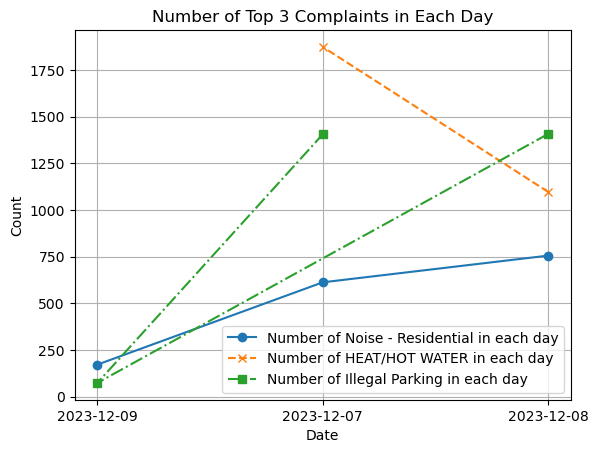

In [119]:
plot_visual_1(df)

## Visualization 2

In [125]:
file_path = "visualize2.csv" 
df2 = pd.read_csv(file_path)

# 显示 DataFrame 的前几行数据
print(df2.head())
complaint_type = df2['complaint_type']
complaint_type

         complaint_type  num_complaints
0   Noise - Residential              35
1        HEAT/HOT WATER              32
2  UNSANITARY CONDITION              21
3         PAINT/PLASTER              15
4              PLUMBING              14


0           Noise - Residential
1                HEAT/HOT WATER
2          UNSANITARY CONDITION
3                 PAINT/PLASTER
4                      PLUMBING
5               Illegal Parking
6            Noise - Commercial
7               FLOORING/STAIRS
8                       GENERAL
9    For Hire Vehicle Complaint
Name: complaint_type, dtype: object

In [ ]:
def get_data_for_visual_2():
    """ 
    Write a query to get data from database for Visualization 2 and return to a dataframe 
    
    """

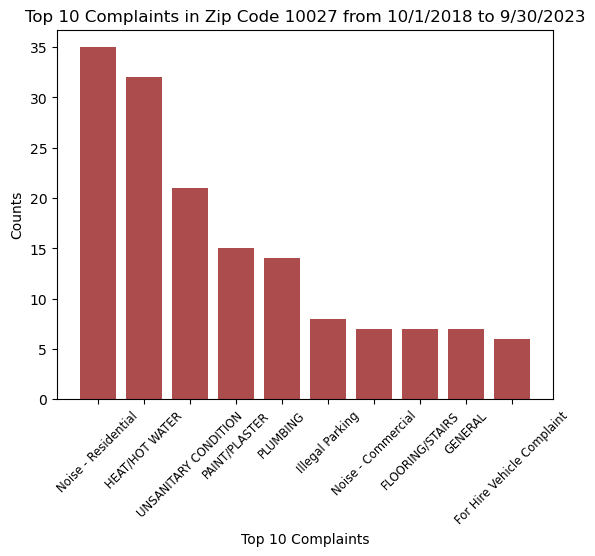

In [133]:
def plot_visual_2(df):
    """Plot a bar graph of the number of top 10 complaints in zip code 10027 for 10/1/2018 to 9/30/2023
    
    Keyword arguments:
    df -- a dataframe contains the top 10 complaint type and number of each type
    """

    complaint_type = df['complaint_type']
    count = df['num_complaints']

    x = range(len(complaint_type))

    plt.bar(x, count, label='', color='darkred', alpha=0.7)  
    
    plt.title(r'Top 10 Complaints in Zip Code 10027 from 10/1/2018 to 9/30/2023')  
    plt.xlabel('Top 10 Complaints')  
    plt.ylabel('Counts') 
    plt.xticks(x, complaint_type, rotation=45, fontsize='small')
    
    plt.show()

plot_visual_2(df2)

## Visualization 3

In [220]:
file_path = "visualize3.csv" 
df3= pd.read_csv(file_path)
print(df3)

column_list = df3['rent'].tolist()
type(column_list)

     zip_code     rent  num_trees  num_complaints
0       11385  2476.92      10262             211
1       11208  2560.47       7896             201
2       10467  1861.07       4079             296
3       11373  2084.55       4014             178
4       11226  2355.61       3706             277
..        ...      ...        ...             ...
116     10280  3692.25        405              58
117     10282  7029.34        230               3
118     11109  3518.93         90               2
119     10006  3489.76         48              10
120     10004  3558.78        117              36

[121 rows x 4 columns]


list

In [ ]:
def get_data_for_visual_3():
    """ 
    Write a query to get data from database for Visualization 3 and return to a dataframe 
    
    """

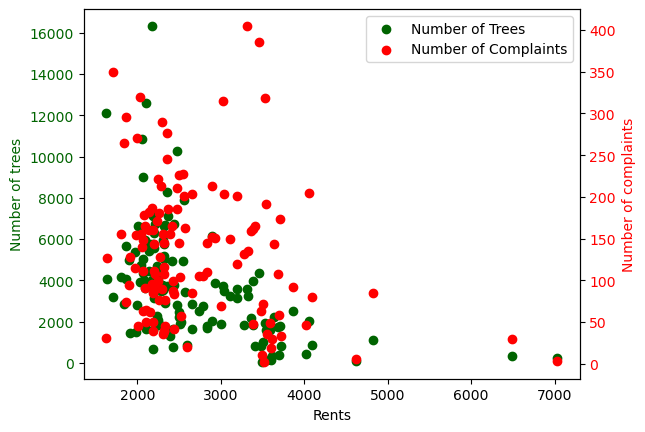

In [227]:
def plot_visual_3(df):
    """Plot a scatter plot of the number of trees and complaints corresponding to rent
    
    Keyword arguments:
    df -- a dataframe contains zipcodes and corresponding average rent, number of trees, and number of complaint
    """
    
    rent= df['rent'].tolist()
    num_trees = df['num_trees']
    num_complaints = df['num_complaints']
    
    # create the first figure
    fig, ax1 = plt.subplots()
    

    # draw the first scatter plot
    ax1.scatter(rent, num_trees, label='Number of Trees', color='darkgreen')
    ax1.set_xlabel('Rents')
    ax1.set_ylabel('Number of trees', color='darkgreen')
    ax1.tick_params(axis='y', labelcolor='darkgreen')

    # create the second figure
    ax2 = ax1.twinx()

    # draw the second scatter plot
    ax2.scatter(rent, num_complaints, label='Number of Complaints', color='red')
    ax2.set_ylabel('Number of complaints', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')

    
    plt.show()
    
plot_visual_3(df3)

## Visualization 4

In [191]:
file_path = "visualize4.csv" 
df4= pd.read_csv(file_path)
print(df4)

'''
# 显示 DataFrame 的前几行数据
bins = list(range(0, 9001, 1000))  # Creating bins in $1000 increments up to $9,000
# print(bins)

    # Bin the average rent data
df4['rent_bin'] = pd.cut(df4['august2023'], bins=bins, labels=bins[:-1])
# print(df4)

result = df4.groupby('rent_bin')['num_complaints'].apply(list).reset_index(name='num_complaints')
print(result)

result_dict = result.set_index('rent_bin')['num_complaints'].to_dict()
print(result_dict)
'''

     zip_code     rent  num_complaints
0       11385  3079.59             211
1       11208  2728.73             201
2       10467  2423.89             296
3       11373  2292.99             178
4       11226  2762.44             277
..        ...      ...             ...
116     10280  4657.35              58
117     10282  7347.46               3
118     11109  4529.36               2
119     10006  4060.10              10
120     10004  4355.33              36

[121 rows x 3 columns]


"\n# 显示 DataFrame 的前几行数据\nbins = list(range(0, 9001, 1000))  # Creating bins in $1000 increments up to $9,000\n# print(bins)\n\n    # Bin the average rent data\ndf4['rent_bin'] = pd.cut(df4['august2023'], bins=bins, labels=bins[:-1])\n# print(df4)\n\nresult = df4.groupby('rent_bin')['num_complaints'].apply(list).reset_index(name='num_complaints')\nprint(result)\n\nresult_dict = result.set_index('rent_bin')['num_complaints'].to_dict()\nprint(result_dict)\n"

In [ ]:
def get_data_for_visual_4():
    """ 
    Write a query to get data from database for Visualization 4 and return to a dataframe 
    
    """

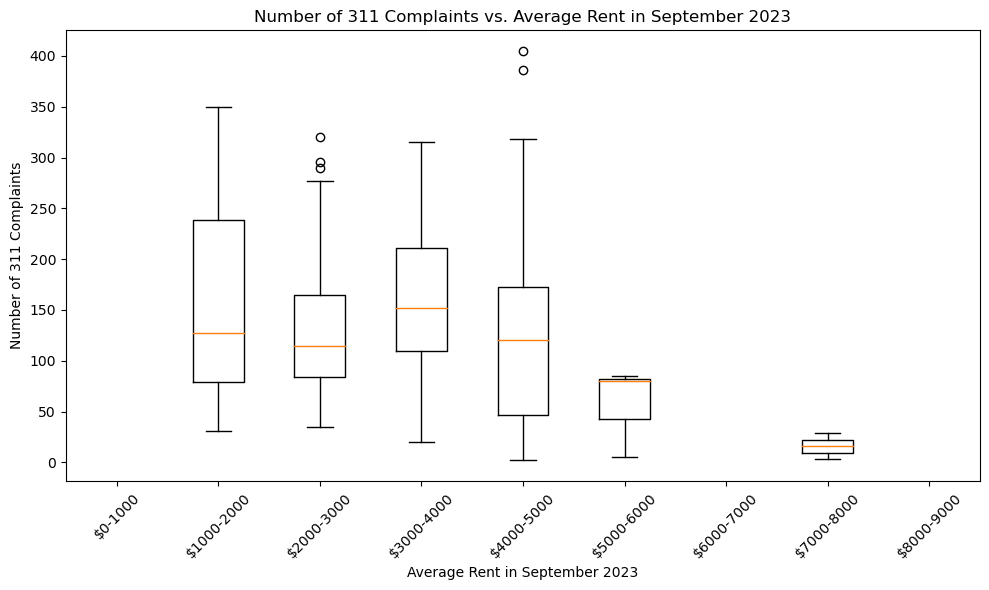

In [192]:
def plot_visual_4(df):
    """Plot a boxplot for number of 311 complaints in each zipcode by rent
    
    Keyword arguments:
    df -- a dataframe contains zipcodes and corresponding average rent and number of complaint
    """
    
    # Create bins for average rent in September 2023
    bins = list(range(0, 9001, 1000))  # Creating bins in $1000 increments up to $9,000

    # Bin the average rent data
    df['rent_bin'] = pd.cut(df['rent'], bins=bins, labels=bins[:-1])
    
    group_rent = df4.groupby('rent_bin')['num_complaints'].apply(list).reset_index(name='num_complaints')
    group_dict = group_rent.set_index('rent_bin')['num_complaints'].to_dict()
    
    # Create a boxplot
    plt.figure(figsize=(10, 6))
    plt.boxplot([group_dict[bin_val] for bin_val in bins[:-1]], labels=[f'${bin_val}-{bin_val+1000}' for bin_val in bins[:-1]])
    plt.title('Number of 311 Complaints vs. Average Rent in September 2023')
    plt.xlabel('Average Rent in September 2023')
    plt.ylabel('Number of 311 Complaints')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()
    
    
plot_visual_4(df4)

## Visualization 5

In [216]:
file_path = "visgeo.csv" 
df5= pd.read_csv(file_path)
print(df5)

type(df5['geometry'][1])

                                              geometry
0    0101000020E6100000F4DC5B5D1E7D52C0648305390867...
1    0101000020E6100000493276B2CD7D52C06F7A5CBB7666...
2    0101000020E61000006240BE6D397D52C0B88A307BD066...
3    0101000020E6100000C11E2B4B017E52C06DC8F3D79066...
4    0101000020E6100000493276B2CD7D52C06F7A5CBB7666...
..                                                 ...
225  0101000020E6100000C85DB3BD327D52C02541308ED166...
226  0101000020E6100000E81B084E377D52C0AF859C842668...
227  0101000020E6100000D41EF7CF9A7D52C03658C62D5B66...
228  0101000020E61000004E421465FE7C52C0D188B21A2A67...
229  0101000020E610000006339FC2057D52C0E6956464DD66...

[230 rows x 1 columns]


str

In [ ]:
def get_data_for_visual_5():
    """ 
    Write a query to get data from database for Visualization 5 and return to a dataframe 
    
    """

In [211]:
def plot_visual_5(df):
    """Plot the location of 311 incidents reported within 1 kilometer radius of Columbia campus between 1/1/2023 and 9/30/2023
    
    Keyword arguments:
    df -- a dataframe contains location of the trees satisfies the requirements
    """

    # Plot the incidents and the buffered area on a map
    figure, axes = plt.subplots(figsize=(20, 10))

    # Plot incidents within the buffered area
    df.plot(ax=axes, marker='o', color='red', markersize=5, label='Complaints within 1km radius')


    plt.title('Reported 311 Incidents within 1km of campus')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()

    
    plt.show()

TypeError: no numeric data to plot

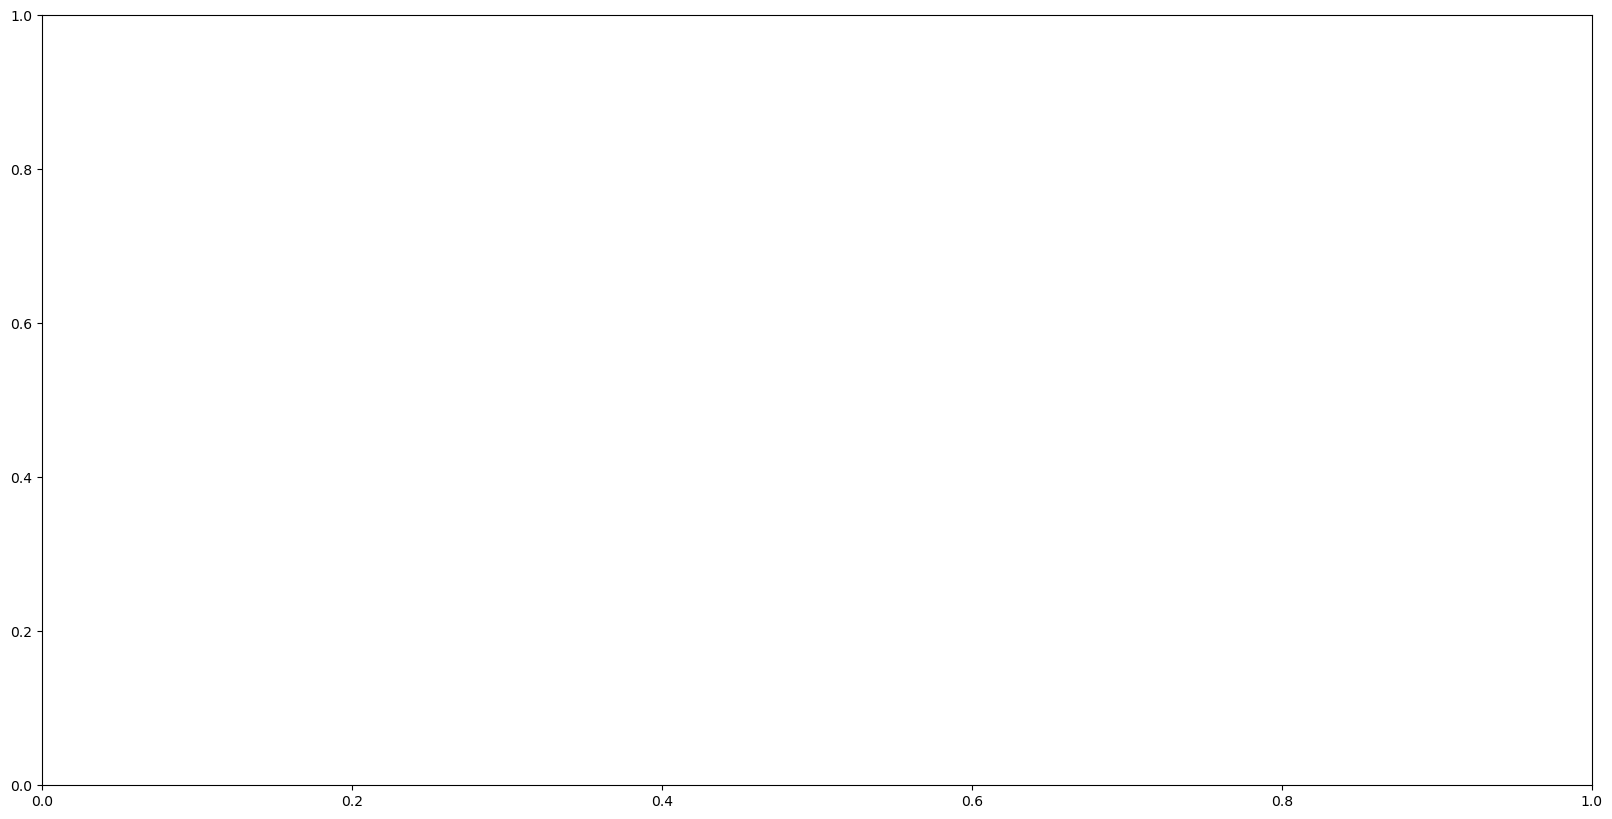

In [212]:
plot_visual_5(df5)

## Visualization 6

In [251]:
file_path = "tree6.csv" 
tree6= pd.read_csv(file_path)

file_path = "complaints6.csv" 
complaints6= pd.read_csv(file_path)

print(tree6)
# type(tree6['geom'][1])
type(complaints6['geom'][1])

                                                 geom
0       POINT (-73.84421521958048 40.723091773924274)
1        POINT (-73.81867945834878 40.79411066708779)
2       POINT (-73.93660770459083 40.717580740099116)
3       POINT (-73.93445615919741 40.713537494833226)
4        POINT (-73.97597938483258 40.66677775537875)
...                                               ...
652162    POINT (-73.95494401022562 40.7132107823145)
652163   POINT (-73.85665019989099 40.71519444267162)
652164   POINT (-74.13651724205825 40.62076152739799)
652165  POINT (-73.90311472453581 40.850828186655754)
652166   POINT (-73.78752645502483 40.73216525220126)

[652167 rows x 1 columns]


str

In [ ]:
def get_data_for_visual_6():
    """ 
    Write a query to get data from database for Visualization 6 and return to a dataframe 
    
    """

TypeError: no numeric data to plot

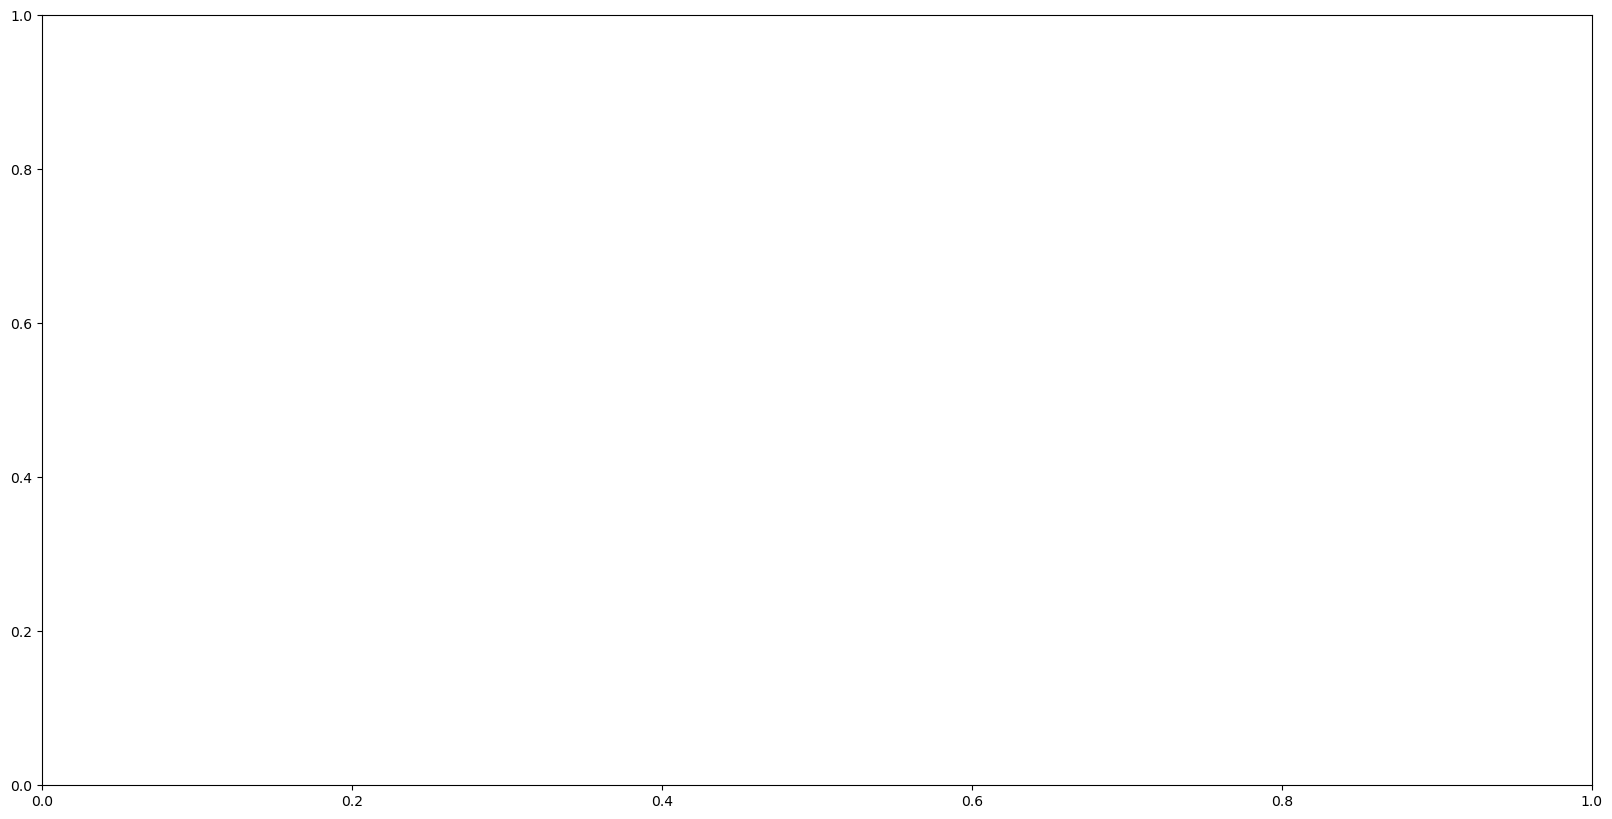

In [235]:
def plot_visual_6(tree, tree_request):
    """Plot the location of trees and request for new trees in NYC
    
    Keyword arguments:
    tree -- a dataframe contains the location of each trees in NYC
    request -- a dataframe contains the locations of 311 requests for new trees in NYC
    """

    # Plotting
    figure, axes = plt.subplots(figsize=(20, 10))

    # Plot trees
    tree.plot(ax=axes, marker='o', color='green', markersize=5, label='Trees')

    # Plot 311 requests
    tree_request.plot(ax=axes, marker='^', color='red', markersize=5, label='Requests for more trees')

    # Add basemap of NYC (if available)

    # Set titles and labels
    plt.title('Tree Coordinates vs. New Tree Request 311 Complaints in NYC')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()

    # Show plot
    plt.show()
    
plot_visual_6(tree6, complaints6)   
    

In [249]:
# use a more descriptive name for your function
def plot_visual_66(test_tree, test_311,test_zipcode):
    # test_zipcode.plot() # 底图
    
    tree_request = test_311[test_311['complaint_type'] == "New Tree Request"]
    # Plotting
    figure, axes = plt.subplots(figsize=(20, 10))
    
    #test_zipcode.plot(ax = axes)
    test_zipcode.plot(ax = axes)
    
    # Plot trees
    test_tree.plot(ax=axes, marker='o', color='green', markersize=5, label='Trees')

    # Plot 311 requests
    tree_request.plot(ax=axes, marker='^', color='red', markersize=5, label='311 Requests')

    # Add basemap of NYC (if available)

    # Set titles and labels
    plt.title('Tree Coordinates vs. New Tree Request 311 Complaints in NYC')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()

    # Show plot
    plt.show()
    
    
    
    
    

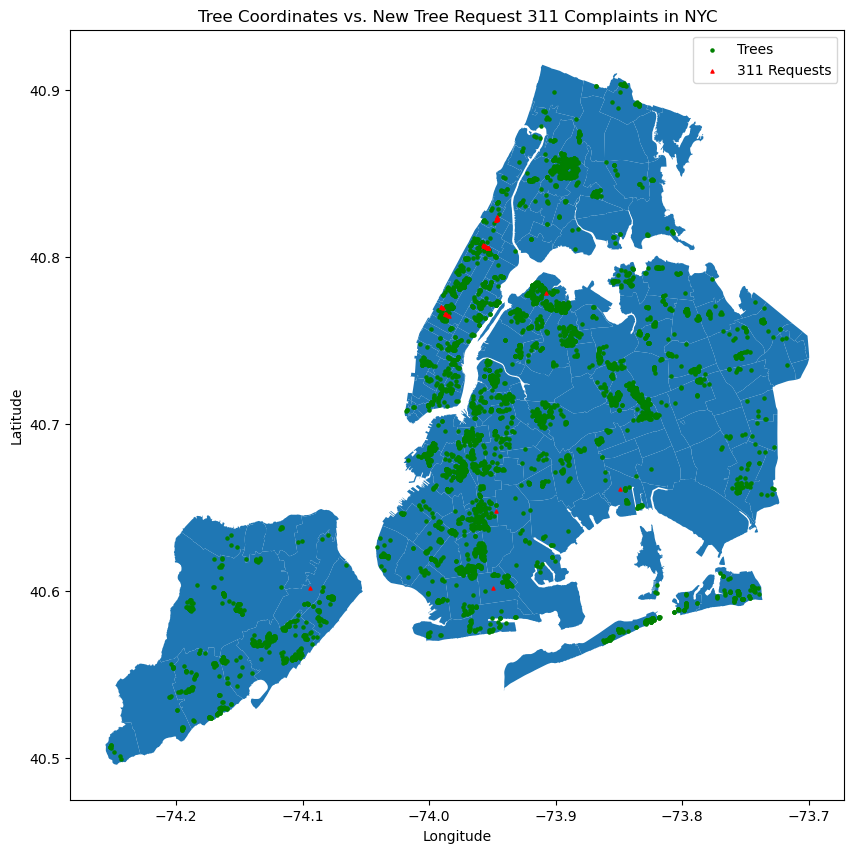

In [250]:
plot_visual_66(test_tree, test_311,test_zipcode)